In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import StratifiedKFold,KFold

In [2]:
from sklearn.preprocessing import LabelEncoder

In [3]:
train_linear = pd.read_csv("../../data/signate-bankcustomer/train_linear2.csv")
test_linear = pd.read_csv("../../data/signate-bankcustomer/test_linear2.csv")

train_tree= pd.read_csv("../../data/signate-bankcustomer/train_tree2.csv")
test_tree = pd.read_csv("../../data/signate-bankcustomer/test_tree2.csv")

In [4]:
train_test_linear = pd.concat([train_linear,test_linear],axis=0)
train_test_tree = pd.concat([train_tree,test_tree],axis=0)

In [5]:
train_test_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 45150 entries, 0 to 18049
Data columns (total 61 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            45150 non-null  int64  
 1   housing            45150 non-null  int64  
 2   loan               45150 non-null  int64  
 3   poutcome           45150 non-null  int64  
 4   edu_unknown_flg    45150 non-null  int64  
 5   balance_minus_flg  45150 non-null  int64  
 6   con_unknown_flg    45150 non-null  int64  
 7   duration_zero_flg  45150 non-null  int64  
 8   pdays_flg          45150 non-null  int64  
 9   pou_unknown_flg    45150 non-null  int64  
 10  age                45150 non-null  float64
 11  balance            45150 non-null  float64
 12  day                45150 non-null  float64
 13  month+day          45150 non-null  float64
 14  duration_sc        45150 non-null  float64
 15  pdays_sc           45150 non-null  float64
 16  job_1250           451

In [6]:
#k-meansでクラスタ分析をする
#人物の属性を表すカラムと銀行側の行動を表すカラムを分けてクラスタ分析を行う
status_column = [
                 "default"
                 ,"housing"
                 ,"loan"
                 ,"balance_minus_flg"
                 ,"edu_unknown_flg"
                 ,"con_unknown_flg"
                 ,"age"
                 ,"balance"
                 ,"job_1250"
                 ,"job_1306"
                 ,"job_1661"
                 ,"job_1884"
                 ,"job_1890"
                 ,"job_4192"
                 ,"job_5339"
                 ,"job_583"
                 ,"job_8128"
                 ,"job_8873"
                 ,"marital_1"
                 ,"marital_2"
                 ,"contact_1"
                 ,"contact_2"
                 ,"education_1771"
                 ,"education_26754"
                 ,"education_5560"
                ]

In [7]:
behavier_column = ["poutcome"
                   ,"duration_zero_flg"
                   ,"pou_unknown_flg"
                   ,"pdays_flg"
                   ,"month+day"
                   ,"duration_sc"
                   ,"pdays_sc"
                   ,"campaign_2"
                   ,"campaign_3"
                   ,"campaign_4"
                   ,"previous_1"
                   ,"previous_2"
                   ,"previous_3"
                   ,"poutcome_1"
                   ,"poutcome_2"
                  ]

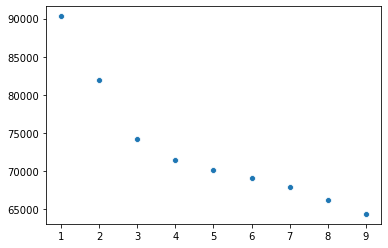

In [8]:
#クラスタを何個に分けるかを決定するために、クラスタ数を１つずつ増やしながら中心までの距離を図示する
from sklearn.cluster import MiniBatchKMeans
sum_dist = []
for i in range(1,10):
    kmeans = MiniBatchKMeans(n_clusters=i,random_state=0)
    kmeans.fit(train_test_linear[status_column])

    distances = kmeans.transform(train_test_linear[status_column])
    
    sum_dist.append(distances.min(axis=1).sum())

sns.scatterplot(range(1,10),sum_dist)

In [9]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=8,random_state=0)

kmeans.fit(train_test_linear[status_column])

distances = kmeans.transform(train_test_linear[status_column])

clusters = kmeans.predict(train_test_linear[status_column])
distances = kmeans.transform(train_test_linear[status_column])

train_test_linear['status_cluster'] = pd.Series(clusters)
train_test_linear['status_distance'] = pd.Series(distances.min(axis=1))

In [10]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

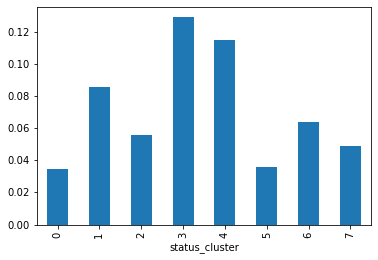

In [11]:
train_linear.groupby(["status_cluster"])["y"].mean().plot(kind="bar")

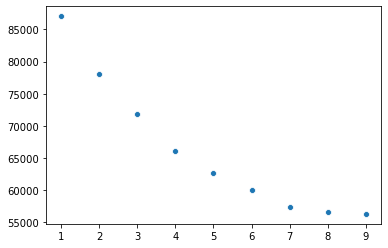

In [12]:
from sklearn.cluster import MiniBatchKMeans
sum_dist = []
for i in range(1,10):
    kmeans = MiniBatchKMeans(n_clusters=i,random_state=0)
    kmeans.fit(train_test_linear[behavier_column])

    distances = kmeans.transform(train_test_linear[behavier_column])
    
    sum_dist.append(distances.min(axis=1).sum())

sns.scatterplot(range(1,10),sum_dist)

In [13]:
from sklearn.cluster import MiniBatchKMeans

kmeans = MiniBatchKMeans(n_clusters=8,random_state=0)

kmeans.fit(train_test_linear[behavier_column])

distances = kmeans.transform(train_test_linear[behavier_column])

clusters = kmeans.predict(train_test_linear[behavier_column])
distances = kmeans.transform(train_test_linear[behavier_column])

train_test_linear['behavier_cluster'] = pd.Series(clusters)
train_test_linear['behavier_distance'] = pd.Series(distances.min(axis=1))

In [14]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]

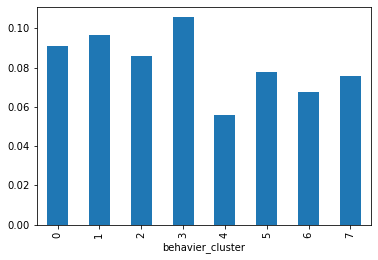

In [15]:
train_linear.groupby(["behavier_cluster"])["y"].mean().plot(kind="bar")

In [16]:
#属するクラスタの中心までの距離を標準化
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
sc.fit(train_test_linear[["status_distance","behavier_distance"]])
train_test_linear[["status_distance","behavier_distance"]] = sc.transform(train_test_linear[["status_distance","behavier_distance"]])

In [17]:
train_test_tree[["status_distance","behavier_distance"]] = train_test_linear[["status_distance","behavier_distance"]]

In [18]:
train_test_tree["status_cluster"] = train_test_linear["status_cluster"]
train_test_tree["behavier_cluster"] = train_test_linear["behavier_cluster"]

In [19]:
#属するクラスタを表すカラムをダミー変数化
sta_clu_dummy = pd.get_dummies(train_test_linear["status_cluster"],drop_first=True,prefix="sta_clu")
beh_clu_dummy = pd.get_dummies(train_test_linear["behavier_cluster"],drop_first=True,prefix="beh_clu")

In [20]:
train_test_linear = pd.concat([train_test_linear,sta_clu_dummy],axis=1)
train_test_linear = pd.concat([train_test_linear,beh_clu_dummy],axis=1)
train_test_linear = train_test_linear.drop(["status_cluster","behavier_cluster"],axis=1)

In [21]:
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [22]:
test_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 0 to 18049
Data columns (total 77 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            18050 non-null  int64  
 1   housing            18050 non-null  int64  
 2   loan               18050 non-null  int64  
 3   poutcome           18050 non-null  int64  
 4   edu_unknown_flg    18050 non-null  int64  
 5   balance_minus_flg  18050 non-null  int64  
 6   con_unknown_flg    18050 non-null  int64  
 7   duration_zero_flg  18050 non-null  int64  
 8   pdays_flg          18050 non-null  int64  
 9   pou_unknown_flg    18050 non-null  int64  
 10  age                18050 non-null  float64
 11  balance            18050 non-null  float64
 12  day                18050 non-null  float64
 13  month+day          18050 non-null  float64
 14  duration_sc        18050 non-null  float64
 15  pdays_sc           18050 non-null  float64
 16  job_1250           180

In [23]:
test_linear = test_linear.drop("y",axis=1)
test_tree = test_tree.drop("y",axis=1)

In [24]:
test_linear.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 0 to 18049
Data columns (total 76 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   default            18050 non-null  int64  
 1   housing            18050 non-null  int64  
 2   loan               18050 non-null  int64  
 3   poutcome           18050 non-null  int64  
 4   edu_unknown_flg    18050 non-null  int64  
 5   balance_minus_flg  18050 non-null  int64  
 6   con_unknown_flg    18050 non-null  int64  
 7   duration_zero_flg  18050 non-null  int64  
 8   pdays_flg          18050 non-null  int64  
 9   pou_unknown_flg    18050 non-null  int64  
 10  age                18050 non-null  float64
 11  balance            18050 non-null  float64
 12  day                18050 non-null  float64
 13  month+day          18050 non-null  float64
 14  duration_sc        18050 non-null  float64
 15  pdays_sc           18050 non-null  float64
 16  job_1250           180

## 新たな特徴量の作成

In [25]:
#年齢を分割
train_test_tree["age_binned"] = pd.qcut(train_test_tree["age"],7,labels=False)
train_test_linear["age_binned"] = train_test_tree["age_binned"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [26]:
#train_linear.groupby(["age_binned"])["y"].mean().plot(kind="bar")

In [27]:
#収入を分割
train_test_tree["balance_binned"] = pd.cut(train_test_tree["balance"],10,labels=False)
train_test_linear["balance_binned"] = train_test_tree["balance_binned"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [28]:
#train_linear.groupby(["balance_binned"])["y"].mean().plot(kind="bar")

In [29]:
#日付を分割したが精度が下がったため不採用
#train_test_tree["day_binned"] = pd.cut(train_test_tree["day"],4,labels=False)
#train_test_linear["day_binned"] = train_test_tree["day_binned"]
#train_linear = train_test_linear[:27100]
#test_linear = train_test_linear[27100:]
#train_tree = train_test_tree[:27100]
#test_tree = train_test_tree[27100:]

In [30]:
#train_linear.groupby(["day_binned"])["y"].mean().plot(kind="bar")

In [31]:
#接触時間を分割
train_test_tree["duration_binned"] = pd.qcut(train_test_tree["duration_sc"],4,labels=False)
train_test_linear["duration_binned"] = train_test_tree["duration_binned"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [32]:
#train_linear.groupby(["duration_binned"])["y"].mean().plot(kind="bar")

In [33]:
train_test_tree["pdays_binned"] = pd.qcut(train_test_tree["pdays_sc"],5,labels=False)
train_test_linear["pdays_binned"] = train_test_tree["pdays_binned"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [34]:
#train_linear.groupby(["pdays_binned"])["y"].mean().plot(kind="bar")

In [35]:
#年齢と収入を掛合わせた特徴を作成
train_test_tree["ageXbalance"] = train_test_tree["age_binned"] * train_test_tree["balance_binned"]
train_test_linear["ageXbalance"] = train_test_tree["ageXbalance"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [36]:
#train_linear.groupby(["ageXbalance"])["y"].mean().plot(kind="bar")

In [37]:
train_tree["ageXbalance"].value_counts()

0     6952
6     1513
12    1395
4     1310
8     1221
18    1073
24    1017
2      878
16     829
5      826
10     772
3      738
36     719
20     705
9      673
30     669
15     602
1      456
14     455
7      445
32     429
35     399
48     383
28     374
42     360
54     357
45     355
40     344
25     325
27     273
21     253
Name: ageXbalance, dtype: int64

In [38]:
#以下で作成する特徴はあまり効果がなかったが一応そのままにしておく

In [39]:
#職業と教育レベルを掛合わせた特徴を作成
train_test_tree["eduXjob"] = train_test_tree["education"] * train_test_tree["job"]
train_test_linear["eduXjob"] = train_test_tree["eduXjob"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [40]:
#train_linear.groupby(["eduXjob"])["y"].mean().plot(kind="bar")

In [41]:
#職業と年齢を掛合わせた特徴を作成
train_test_tree["ageXjob"] = train_test_tree["age_binned"] * train_test_tree["job"]
train_test_linear["ageXjob"] = train_test_tree["ageXjob"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [42]:
#train_linear.groupby(["ageXjob"])["y"].mean().plot(kind="bar")

In [43]:
#職業と収入を掛合わせた特徴を作成
train_test_tree["balanceXjob"] = train_test_tree["balance_binned"] * train_test_tree["job"]
train_test_linear["balanceXjob"] = train_test_tree["balanceXjob"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [44]:
#train_linear.groupby(["balanceXjob"])["y"].mean().plot(kind="bar")

In [45]:
#年齢と教育レベルを掛合わせた特徴を作成
train_test_tree["ageXedu"] = train_test_tree["age_binned"] * train_test_tree["education"]
train_test_linear["ageXedu"] = train_test_tree["ageXedu"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [46]:
#train_linear.groupby(["ageXedu"])["y"].mean().plot(kind="bar")

In [47]:
#年齢と連絡手段を掛け合わせた特徴を作成
train_test_tree["ageXcontact"] = train_test_tree["age_binned"] * train_test_tree["contact"]
train_test_linear["ageXcontact"] = train_test_tree["ageXcontact"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [48]:
#train_linear.groupby(["ageXcontact"])["y"].mean().plot(kind="bar")

In [49]:
#収入と連絡手段を掛け合わせた特徴を作成
train_test_tree["balanceXcontact"] = train_test_tree["balance_binned"] * train_test_tree["contact"]
train_test_linear["balanceXcontact"] = train_test_tree["balanceXcontact"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [50]:
#train_linear.groupby(["balanceXcontact"])["y"].mean().plot(kind="bar")

In [51]:
#接触時間と連絡手段を掛け合わせた特徴を作成
train_test_tree["durationXcontact"] = train_test_tree["duration_sc"] * train_test_tree["contact"]
train_test_linear["durationXcontact"] = train_test_tree["durationXcontact"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [52]:
#train_linear.groupby(["y"])["durationXcontact"].mean().plot(kind="bar")

In [53]:
#接触時間と前回のキャンペーンの反応を掛け合わせた特徴を作成
train_test_tree["durationXpoutcome"] = train_test_tree["duration_sc"] * train_test_tree["poutcome"]
train_test_linear["durationXpoutcome"] = train_test_tree["durationXpoutcome"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [54]:
#train_linear.groupby(["y"])["durationXpoutcome"].mean().plot(kind="bar")

In [55]:
#最終接触日と前回のキャンペーンの反応を掛け合わせた特徴を作成
train_test_tree["pdaysXpoutcome"] = train_test_tree["pdays_sc"] * train_test_tree["poutcome"]
train_test_linear["pdaysXpoutcome"] = train_test_tree["pdaysXpoutcome"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [56]:
#train_linear.groupby(["y"])["pdaysXpoutcome"].mean().plot(kind="bar")

In [57]:
#職業と月を掛合わせた特徴を作成
train_test_tree["jobXmonth"] = train_test_tree["job"] * train_test_tree["month"]
train_test_linear["jobXmonth"] = train_test_tree["jobXmonth"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [58]:
#train_linear.groupby(["jobXmonth"])["y"].mean().plot(kind="bar")

In [59]:
#年齢と「既婚・独身」を掛合わせた特徴を作成
train_test_tree["ageXmarital"] = train_test_tree["age_binned"] * train_test_tree["marital"]
train_test_linear["ageXmarital"] = train_test_tree["ageXmarital"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [60]:
#train_linear.groupby(["ageXmarital"])["y"].mean().plot(kind="bar")

In [61]:
#職業と「既婚・独身」を掛合わせた特徴を作成
train_test_tree["jobXmarital"] = train_test_tree["job"] * train_test_tree["marital"]
train_test_linear["jobXmarital"] = train_test_tree["jobXmarital"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [62]:
#train_linear.groupby(["jobXmarital"])["y"].mean().plot(kind="bar")

In [63]:
#教育レベルと「既婚・独身」を掛合わせた特徴を作成
train_test_tree["eduXmarital"] = train_test_tree["education"] * train_test_tree["marital"]
train_test_linear["eduXmarital"] = train_test_tree["eduXmarital"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [64]:
#train_linear.groupby(["eduXmarital"])["y"].mean().plot(kind="bar")

In [65]:
#教育レベルと連絡手段を掛合わせた特徴を作成
train_test_tree["eduXcontact"] = train_test_tree["education"] * train_test_tree["contact"]
train_test_linear["eduXcontact"] = train_test_tree["eduXcontact"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [66]:
#train_linear.groupby(["eduXcontact"])["y"].mean().plot(kind="bar")

In [67]:
#教育レベルと前回のキャンペーンの反応を掛合わせた特徴を作成
train_test_tree["eduXpoutcome"] = train_test_tree["education"] * train_test_tree["poutcome"]
train_test_linear["eduXpoutcome"] = train_test_tree["eduXpoutcome"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [68]:
#train_linear.groupby(["eduXpoutcome"])["y"].mean().plot(kind="bar")

In [69]:
#職業と前回のキャンペーンの反応を掛合わせた特徴を作成
train_test_tree["jobXpoutcome"] = train_test_tree["job"] * train_test_tree["poutcome"]
train_test_linear["jobXpoutcome"] = train_test_tree["jobXpoutcome"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [70]:
#train_linear.groupby(["jobXpoutcome"])["y"].mean().plot(kind="bar")

In [71]:
#教育レベルと収入を掛合わせた特徴を作成
train_test_tree["eduXbalance"] = train_test_tree["education"] * train_test_tree["balance_binned"]
train_test_linear["eduXbalance"] = train_test_tree["eduXbalance"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [72]:
#train_linear.groupby(["eduXbalance"])["y"].mean().plot(kind="bar")

In [73]:
#収入と「既婚・独身」を掛合わせた特徴を作成
train_test_tree["balanceXmarital"] = train_test_tree["balance_binned"] * train_test_tree["marital"]
train_test_linear["balanceXmarital"] = train_test_tree["balanceXmarital"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [74]:
#train_linear.groupby(["balanceXmarital"])["y"].mean().plot(kind="bar")

In [75]:
#収入を年齢で割った特徴を作成(年齢が高いと収入が増えるため、収入に対する年齢の影響を除去)
train_test_tree["balance/age"] = train_test_tree["balance"] * train_test_tree["age"]
train_test_linear["balance/age"] = train_test_tree["balance/age"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [76]:
#train_linear.groupby(["y"])["balance/age"].describe()

In [77]:
#現キャンペーンでの接触回数と前回のキャンペーンでの接触回数を合計した特徴を作成
train_test_tree["campaign+previous"] = train_test_tree["campaign"] * train_test_tree["previous"]
train_test_linear["campaign+previous"] = train_test_tree["campaign+previous"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [78]:
#train_linear.groupby(["campaign+previous"])["y"].mean().plot(kind="bar")

In [79]:
#接触時間を接触回数で割った平均接触時間の特徴を作成
train_test_tree["duration/num"] = train_test_tree["duration_binned"] * train_test_tree["campaign+previous"]
train_test_linear["duration/num"] = train_test_tree["duration/num"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [80]:
#train_linear.groupby(["duration/num"])["y"].mean().plot(kind="bar")

In [81]:
#キャンペーンでの接触回数と接触時間を掛けた特徴を作成
train_test_tree["durationXcampaign"] = train_test_tree["duration_binned"] + train_test_tree["campaign"]
train_test_linear["durationXcampaign"] = train_test_tree["durationXcampaign"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [82]:
#train_linear.groupby(["durationXcampaign"])["y"].mean().plot(kind="bar")

In [83]:
#接触時間と年齢を掛けた特徴を作成
train_test_tree["durationXage"] = train_test_tree["duration_binned"] + train_test_tree["age_binned"]
train_test_linear["durationXage"] = train_test_tree["durationXage"]
train_linear = train_test_linear[:27100]
test_linear = train_test_linear[27100:]
train_tree = train_test_tree[:27100]
test_tree = train_test_tree[27100:]

In [84]:
#train_linear.groupby(["durationXage"])["y"].mean().plot(kind="bar")

In [85]:
#作成した特徴のターゲットエンコーディングを行う
cat_columns = ["status_cluster","behavier_cluster","age_binned","balance_binned","duration_binned"
               ,"pdays_binned","ageXbalance","eduXjob","ageXjob"
               ,"balanceXjob","ageXedu","ageXcontact","balanceXcontact"
               ,"jobXmonth"
               ,"ageXmarital","jobXmarital","eduXmarital","eduXcontact"
               ,"eduXpoutcome","jobXpoutcome","eduXbalance","balanceXmarital"
               ,"campaign+previous","duration/num","durationXcampaign","durationXage"
              ]

In [86]:
#テストデータのターゲットエンコーディング
for c in cat_columns:
    test_tree[c] = test_tree[c].map(train_tree.groupby(c)["y"].mean())
    test_tree[c] = test_tree[c].fillna(train_tree.groupby(c)["y"].mean().mean())

<ipython-input-86-483f15c1b83e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tree[c] = test_tree[c].map(train_tree.groupby(c)["y"].mean())
<ipython-input-86-483f15c1b83e>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_tree[c] = test_tree[c].fillna(train_tree.groupby(c)["y"].mean().mean())


In [87]:
test_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 18050 entries, 0 to 18049
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   job                18050 non-null  int64  
 1   marital            18050 non-null  int64  
 2   education          18050 non-null  int64  
 3   default            18050 non-null  int64  
 4   housing            18050 non-null  int64  
 5   loan               18050 non-null  int64  
 6   contact            18050 non-null  int64  
 7   month              18050 non-null  int64  
 8   campaign           18050 non-null  int64  
 9   previous           18050 non-null  int64  
 10  poutcome           18050 non-null  int64  
 11  edu_unknown_flg    18050 non-null  int64  
 12  balance_minus_flg  18050 non-null  int64  
 13  con_unknown_flg    18050 non-null  int64  
 14  duration_zero_flg  18050 non-null  int64  
 15  pdays_flg          18050 non-null  int64  
 16  pou_unknown_flg    180

In [88]:
#訓練データのターゲットエンコーディング
n_split = 5

skf = StratifiedKFold(n_splits=n_split,shuffle=True,random_state=0)
for c in cat_columns:
    tmp = np.repeat(np.nan,train_tree.shape[0])
    for train_idx,valid_idx in skf.split(train_tree,train_tree["y"]):
        target_mean = train_tree.iloc[train_idx].groupby(c)["y"].mean()
        tmp[valid_idx] = train_tree[c].iloc[valid_idx].map(target_mean)
        train_tree[c].iloc[valid_idx] = train_tree[c].iloc[valid_idx].fillna(target_mean.mean())
    train_tree[c] = tmp

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/indexing.py:671: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)
<ipython-input-88-778fa00078e9>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_tree[c].iloc[valid_idx] = train_tree[c].iloc[valid_idx].fillna(target_mean.mean())
<ipython-input-88-778fa00078e9>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#r

In [89]:
train_linear[cat_columns] = train_tree[cat_columns]
test_linear[cat_columns] = test_tree[cat_columns]

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/frame.py:2963: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [90]:
test_linear = test_linear.drop("y",axis=1)
test_tree = test_tree.drop("y",axis=1)

In [91]:
#ターゲットエンコーディングで欠損値となってしまったデータは中央値で埋める
train_linear["jobXmonth"] = train_linear["jobXmonth"].fillna(train_linear["jobXmonth"].median())
train_linear["duration/num"] = train_linear["duration/num"].fillna(train_linear["duration/num"].median())
test_linear["jobXmonth"] = test_linear["jobXmonth"].fillna(test_linear["jobXmonth"].median())
test_linear["duration/num"] = test_linear["duration/num"].fillna(test_linear["duration/num"].median())

train_tree["jobXmonth"] = train_linear["jobXmonth"]
train_tree["duration/num"] = train_linear["duration/num"]
test_tree["jobXmonth"] = test_linear["jobXmonth"]
test_tree["duration/num"] = test_linear["duration/num"]

train_test_linear = pd.concat([train_linear,test_linear],axis=0)
train_test_tree = pd.concat([train_tree,test_tree],axis=0)


<ipython-input-91-84b9be247a94>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_linear["jobXmonth"] = train_linear["jobXmonth"].fillna(train_linear["jobXmonth"].median())
<ipython-input-91-84b9be247a94>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_linear["duration/num"] = train_linear["duration/num"].fillna(train_linear["duration/num"].median())
<ipython-input-91-84b9be247a94>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_i

In [92]:
train_tree.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 27100 entries, 0 to 27099
Data columns (total 65 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   job                27100 non-null  int64  
 1   marital            27100 non-null  int64  
 2   education          27100 non-null  int64  
 3   default            27100 non-null  int64  
 4   housing            27100 non-null  int64  
 5   loan               27100 non-null  int64  
 6   contact            27100 non-null  int64  
 7   month              27100 non-null  int64  
 8   campaign           27100 non-null  int64  
 9   previous           27100 non-null  int64  
 10  poutcome           27100 non-null  int64  
 11  edu_unknown_flg    27100 non-null  int64  
 12  balance_minus_flg  27100 non-null  int64  
 13  con_unknown_flg    27100 non-null  int64  
 14  duration_zero_flg  27100 non-null  int64  
 15  pdays_flg          27100 non-null  int64  
 16  pou_unknown_flg    271

In [93]:
#スタッキングで得た予測値（分類確率）を標準化したが精度が下がったため不採用
#from sklearn.preprocessing import StandardScaler,PowerTransformer

In [94]:
#sc = StandardScaler()

In [95]:
#num_columns = ["prob_1","prob_2","prob_3","prob_4","prob_5","prob_6","prob_7","prob_8","prob_9"]

In [96]:
#train_test_tree[num_columns].describe()

In [97]:
#sns.distplot(train_test_tree["prob_1"])

In [98]:
#train_test_tree["prob_5"] = train_test_tree["prob_5"] + 0.000300
#train_test_tree["prob_9"] = train_test_tree["prob_9"] + 0.000300

In [99]:
#pt = PowerTransformer(method="box-cox")
#pt.fit(train_test_tree[num_columns])
#rain_test_tree[num_columns] = pt.transform(train_test_tree[num_columns])
#train_test_linear[num_columns] = train_test_tree[num_columns]

In [100]:
#train_test_linear[num_columns].describe()

In [101]:
#train_test_tree[num_columns].describe()

In [102]:
#sns.distplot(train_test_tree["prob_9"])

In [103]:
#sc.fit(train_test_tree[num_columns])
#train_test_tree[num_columns] = pd.DataFrame(sc.transform(train_test_tree[num_columns]),columns = num_columns)
#train_test_linear[num_columns] = pd.DataFrame(sc.transform(train_test_linear[num_columns]),columns = num_columns)

#train_linear = train_test_linear[:27100]
#test_linear = train_test_linear[27100:]
#train_tree = train_test_tree[:27100]
#test_tree = train_test_tree[27100:]


In [104]:
#train_linear[num_columns].describe()

In [105]:
#sns.distplot(train_tree["prob_9"])

In [106]:
#test_linear = test_linear.drop("y",axis=1)
#test_tree = test_tree.drop("y",axis=1)

In [107]:
train_linear.to_csv("../../data/signate-bankcustomer/train_linear3.csv",index=False)
test_linear.to_csv("../../data/signate-bankcustomer/test_linear3.csv",index=False)

train_tree.to_csv("../../data/signate-bankcustomer/train_tree3.csv",index=False)
test_tree.to_csv("../../data/signate-bankcustomer/test_tree3.csv",index=False)

In [108]:
train_linear.isnull().sum().sum()

0

In [109]:
test_linear.isnull().sum().sum()

0

In [110]:
train_tree.isnull().sum().sum()

0

In [111]:
test_tree.isnull().sum().sum()

0